<a href="https://colab.research.google.com/github/Amitsen1014/gcp-amit/blob/main/Stock_Pridction_Classification_and_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                   Stock Market Price Prediction ML Project
## Problem Statement

The goal of this project is to analyze and predict stock market behavior using machine learning techniques.  
We focus on two core tasks:

- **Regression**: Predict the next day's stock closing price.
- **Classification**: Predict the trend (Up/Down) of stock prices.

This dual approach will help in both continuous price estimation and directional prediction, useful for financial forecasting.


##Data Collection

We use the `yfinance` Python library to collect historical stock market data from Yahoo Finance.

- Ticker: e.g., `"TCS.NS"`
- Time Period: Last 30 Days
- Frequency: 15 min data

The data includes features like `Open`, `High`, `Low`, `Close`, and `Volume`, which we will use for both classification and regression tasks.


In [ ]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("TCS.NS")  # Use any NSE stock
# Fetch stock data for TCS from the last 30 Days
df = ticker.history(period="30d", interval="15m")
df.to_csv("stock_data.csv")


In [ ]:
from google.colab import drive # Mount Goodle Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install category_encoders #Install library for Category Encoders

In [ ]:
#Importing important required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.metrics import r2_score,accuracy_score,mean_squared_error,precision_score,f1_score,roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
df = pd.read_csv("/content/stock_data.csv") #Fetching Csv File from Google Drive

In [ ]:
df.head() #Analyzing first 5 rows of dataset

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-06-16 09:15:00+05:30,3440.100098,3476.600098,3434.800049,3470.0,59007,0.0,0.0
1,2025-06-16 09:30:00+05:30,3469.800049,3474.000000,3463.399902,3469.5,51460,0.0,0.0
2,2025-06-16 09:45:00+05:30,3469.899902,3472.399902,3460.000000,3465.5,49225,0.0,0.0
3,2025-06-16 10:00:00+05:30,3465.000000,3473.500000,3461.399902,3472.5,28127,0.0,0.0
4,2025-06-16 10:15:00+05:30,3472.500000,3487.199951,3472.000000,3485.0,83532,0.0,0.0


In [ ]:
df.info() #Checking For Datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime      750 non-null    object 
 1   Open          750 non-null    float64
 2   High          750 non-null    float64
 3   Low           750 non-null    float64
 4   Close         750 non-null    float64
 5   Volume        750 non-null    int64  
 6   Dividends     750 non-null    float64
 7   Stock Splits  750 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
df.isnull().sum()  #No missing Value Found

,0
Datetime,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,750.0
mean,3347.586799,3350.985328,3343.536269,3347.102002,1.071926e+05,0.014667,0.0
std,117.762987,118.238804,117.437318,117.839324,1.242051e+05,0.401663,0.0
min,3134.899902,3135.500000,3126.800049,3135.000000,9.265000e+03,0.000000,0.0
25%,3230.424927,3234.274963,3227.000000,3230.500000,4.494550e+04,0.000000,0.0
50%,3407.700073,3410.500000,3402.900024,3407.050049,7.295150e+04,0.000000,0.0
75%,3434.474976,3438.974976,3430.899902,3434.250061,1.246552e+05,0.000000,0.0
max,3523.899902,3538.000000,3516.000000,3523.500000,2.299199e+06,11.000000,0.0


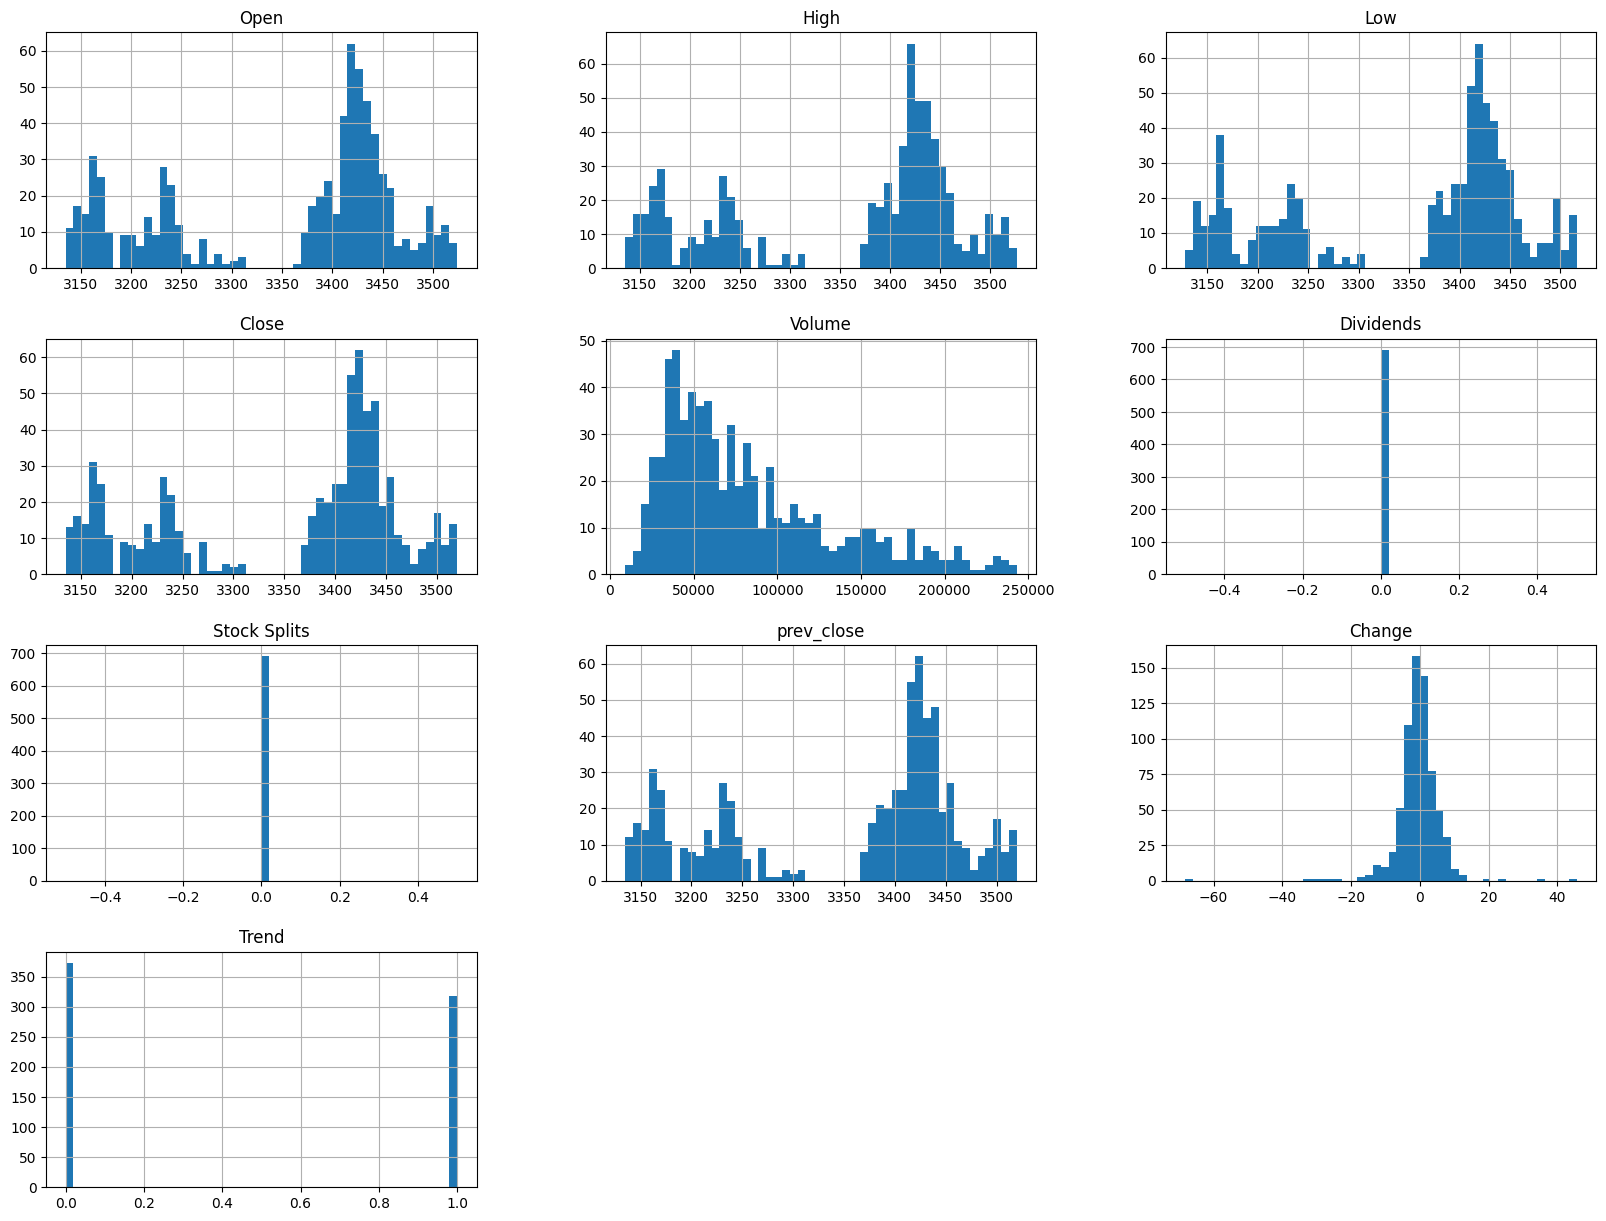

In [ ]:
# Plotting Histogram to understand Data Distribution
df.hist(bins=50,figsize=(20,15))
plt.show()

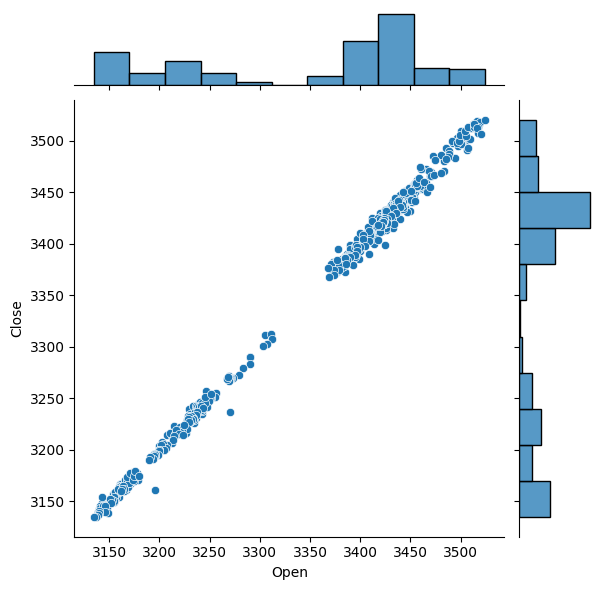

In [ ]:
# Plotting Joint Plot to understand multivariant analysis
sns.jointplot(data=df,x="Open",y="Close")
plt.show()

In [ ]:
# Print all unique values in the 'Volume' column before outlier removal
print(df["Volume"].unique())

# Calculate the first quartile (25th percentile) of the Volume column
Q1 = df["Volume"].quantile(0.25)

# Calculate the third quartile (75th percentile) of the Volume column
Q3 = df["Volume"].quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define lower bound for outliers
lower = Q1 - 1.5 * IQR

# Define upper bound for outliers
upper = Q3 + 1.5 * IQR

# Filter the dataframe to keep only non-outlier rows in 'Volume'
df = df[(df["Volume"] >= lower) & (df["Volume"] <= upper)]

# Print the unique values in 'Volume' after removing outliers
print(df["Volume"].unique())


[  59007   51460   49225   28127   83532   66821  133388   84169  110440
   79718   54028   41690   25838  100259   39264   40197   71416   43329
   48286   35450   34434   47837   58885  156615  320000  191155   73774
   36825   22197   37428   67247   31114  105997  115388  115465   98454
   43331   83925   59153   95098   71376   49645   63646   80690   83977
   72843   75619   66956  188749  181803  499658  113461   56887  120388
  118222   86659  314132   39399   87016   48687   42012   42003   54415
   60363   56931   35442   36235   70089   65308   81088  120489   59916
   86876  207929  192582  206008   62221   87228   49375   23669  198634
  135588   46108   50651   80891   41053   74195   74924   58609   70824
   74633   35540   61848   28418  116398   56296   95632   73308  392501
  477981   36645   39073  355786   28320  110757   55797   42876   21881
   36023   21511   64556   30110   22616   27802   30882   32458   27196
   26154   39265   38152   26690   48705   98367  5

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692 entries, 0 to 747
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime      692 non-null    object 
 1   Open          692 non-null    float64
 2   High          692 non-null    float64
 3   Low           692 non-null    float64
 4   Close         692 non-null    float64
 5   Volume        692 non-null    int64  
 6   Dividends     692 non-null    float64
 7   Stock Splits  692 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 48.7+ KB


In [ ]:
# Create a new column 'prev_close' containing the previous day's closing price
df["prev_close"] = df["Close"].shift(1)

# Calculate the daily price change by subtracting previous close from current close
df["Change"] = df["Close"] - df["prev_close"]

# Create a binary target column 'Trend': 1 if price increased, 0 if not
df["Trend"] = (df["Change"] > 0).astype(int)

# Remove the first row (and any others with NaN) caused by the shift operation
df = df.dropna()

# Display the first few rows of the updated DataFrame
df.head()


/tmp/ipython-input-43-1235689878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prev_close"] = df["Close"].shift(1)
/tmp/ipython-input-43-1235689878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Change"] = df["Close"] - df["prev_close"]
/tmp/ipython-input-43-1235689878.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,prev_close,Change,Trend
1,2025-06-16 09:30:00+05:30,3469.800049,3474.000000,3463.399902,3469.500000,51460,0.0,0.0,3470.0,-0.500000,0
2,2025-06-16 09:45:00+05:30,3469.899902,3472.399902,3460.000000,3465.500000,49225,0.0,0.0,3469.5,-4.000000,0
3,2025-06-16 10:00:00+05:30,3465.000000,3473.500000,3461.399902,3472.500000,28127,0.0,0.0,3465.5,7.000000,1
4,2025-06-16 10:15:00+05:30,3472.500000,3487.199951,3472.000000,3485.000000,83532,0.0,0.0,3472.5,12.500000,1
5,2025-06-16 10:30:00+05:30,3485.000000,3493.800049,3484.000000,3492.800049,66821,0.0,0.0,3485.0,7.800049,1


In [ ]:
# Seperating numerical and Categorical Fields
df_num = df.select_dtypes(include=['float64', 'int64'])

#Creating Categorical Data Frame
df_cat = df.select_dtypes(include=['object'])

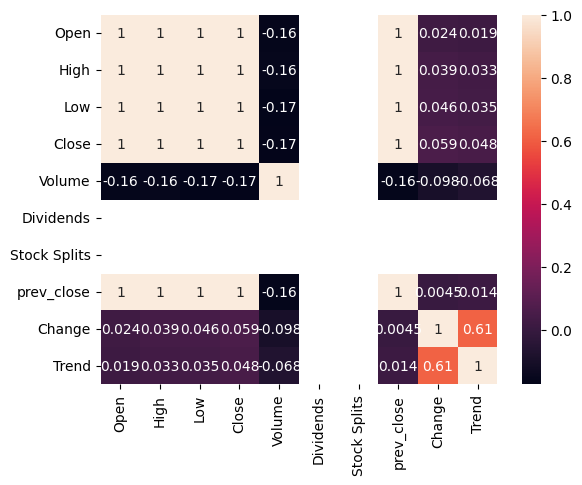

In [ ]:
corrs= df_num.corr() #Getting Correlation Cofficient

sns.heatmap(corrs,annot=True) #Create heatmap
plt.show()

## 🔍 Multicollinearity Check Using VIF (Variance Inflation Factor)
To ensure that the features used in our model are not highly correlated with each other, we calculate the Variance Inflation Factor (VIF). A high VIF indicates that the variable is collinear with other predictors, which may negatively impact the model's performance.


In [ ]:
# Select only numeric columns for VIF analysis
df_num = df.select_dtypes(include=['float64', 'int64'])

# Import function to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create an empty DataFrame to store VIF values
vif_data = pd.DataFrame()

# Add a column 'feature' containing the names of numeric features
vif_data["feature"] = df_num.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i)
                   for i in range(len(df_num.columns))]

# Display the calculated VIF values
print(vif_data)


        feature           VIF
0          Open  3.013719e+06
1          High  2.766223e+06
2           Low  2.429882e+06
3         Close           inf
4        Volume  4.058865e+00
5     Dividends           NaN
6  Stock Splits           NaN
7    prev_close           inf
8        Change           inf
9         Trend  3.586503e+00


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [ ]:
x = df[["Open","High","Volume","prev_close"]] # Extracitng X Variables/Input Variables
y_Classification = df["Trend"]  # Target For Classifiation
y_regression  = df["Close"]    # Target For Regression

## ⚖️ Feature Scaling Using RobustScaler
To make features more comparable and improve model performance, we scale them using `RobustScaler`. This scaler is robust to outliers, as it uses the median and interquartile range (IQR) instead of mean and standard deviation.


In [ ]:
# Initialize the RobustScaler
Scaler = RobustScaler()

# Fit the scaler on the feature set and transform it
xscale = Scaler.fit_transform(x)

# Convert the scaled data back to a DataFrame with original column names
x = pd.DataFrame(xscale, columns=x.columns)

# Display the scaled features
x.head()


,Open,High,Volume,prev_close
0,0.291410,0.298435,-0.240539,0.295639
1,0.291902,0.290606,-0.274603,0.293176
2,0.267782,0.295988,-0.596165,0.273466
3,0.304701,0.363014,0.248282,0.307958
4,0.366232,0.395304,-0.006417,0.369549


In [ ]:
# Model for Classification Target Prediction
xtrain,xtest,ytrain_class,ytest_class = train_test_split(x,y_Classification,test_size=0.2,random_state=42) # SPlit train test split for Classification

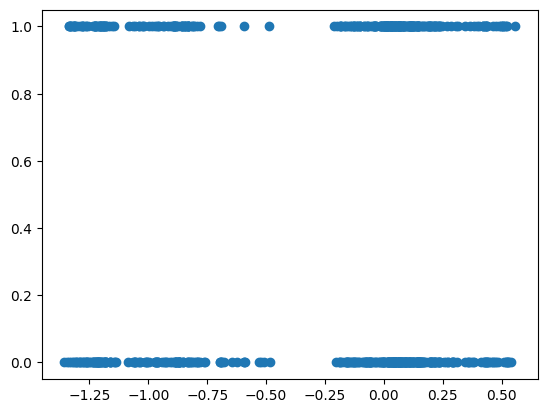

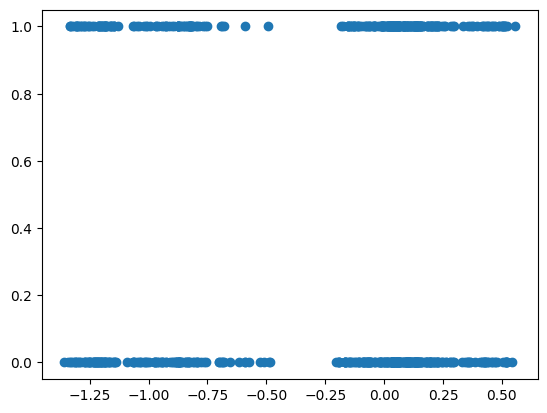

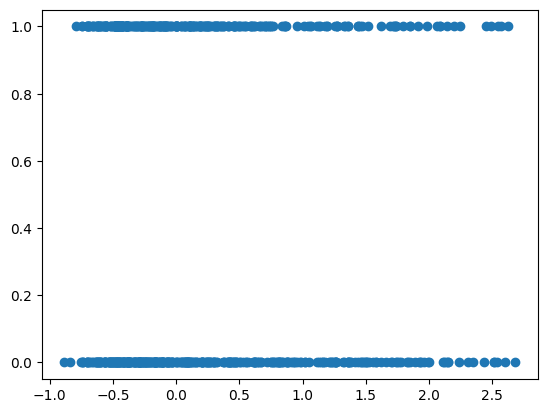

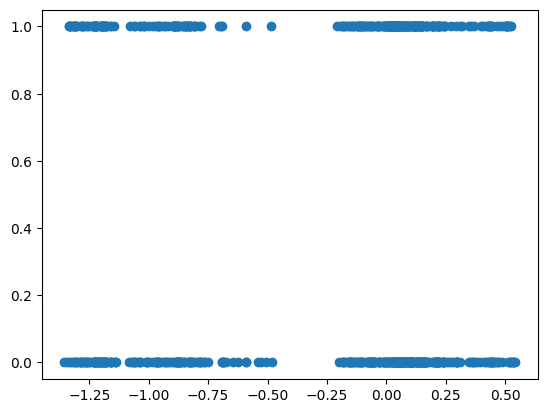

In [ ]:
for col in x.columns:
  plt.scatter(x=x[col],y=y_Classification) # For Bivariant Analysis
  plt.show()

In [ ]:
# Decision Tree Classification Model preparation
model = DecisionTreeClassifier()
model.fit(xtrain,ytrain_class) # Model Fitting into Training sets
ypredict_class = model.predict(xtest) #Prediction based on Model preparation

## ✅ Classification Model Evaluation Metrics
After predicting the target variable (e.g., trend up/down), we evaluate the classification model using three main metrics:  
- **Accuracy**: Overall how often the model is correct  
- **Precision**: How many of the predicted positives are actually positive  
- **F1 Score**: Harmonic mean of precision and recall (useful when class distribution is imbalanced)


In [ ]:
accuracyscore = accuracy_score(ytest_class,ypredict_class)
print(accuracyscore) # Accuracy Score
precesionscore = precision_score(ytest_class,ypredict_class)
print(precesionscore) # Precision Score
f1score = f1_score(ytest_class,ypredict_class)
print(f1score)  ## F1 Score

0.6187050359712231
0.5625
0.576


In [ ]:
# Instantiate the logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(xtrain, ytrain_class)

# Predict the class labels on the test data
ypredict_class = model.predict(xtest)

# Calculate and print the accuracy score
accuracyscore = accuracy_score(ytest_class, ypredict_class)
print("Accuracy Score:", accuracyscore)

# Calculate and print the precision score
precesionscore = precision_score(ytest_class, ypredict_class)
print("Precision Score:", precesionscore)

# Calculate and print the F1 score
f1score = f1_score(ytest_class, ypredict_class)
print("F1 Score:", f1score)


Accuracy Score: 0.5683453237410072
Precision Score: 0.5217391304347826
F1 Score: 0.2857142857142857


In [ ]:
# ================================================
# Stratified K-Fold Cross Validation (Manual + Sklearn)
# ================================================

# 📦 Import required library
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 📌 Define number of splits
n_splits = 5

# 📝 List to store accuracy scores from manual loop
accuracy_scores = []

# 🔁 Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 🚀 Manual Cross Validation Loop
for train_index, test_index in skf.split(x, y_Classification):
    # 🔄 Split data into train and test sets for current fold
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y_Classification.iloc[train_index], y_Classification.iloc[test_index]

    # 🎯 Initialize and fit the model
    model = DecisionTreeClassifier()
    model.fit(xtrain, ytrain)

    # 📊 Make predictions and calculate accuracy
    ypredict_class = model.predict(xtest)
    score = accuracy_score(ytest, ypredict_class)
    accuracy_scores.append(score)

# 📈 Output accuracy scores from manual K-Fold
print("Manual Fold Accuracy Scores:", accuracy_scores)

# 🧪 Sklearn's built-in cross_val_score (for comparison)
score = cross_val_score(DecisionTreeClassifier(), x, y_Classification, cv=skf)
print("cross_val_score Accuracy Scores:", score)

# 📊 Average Accuracy Score from manual loop
print("Average Accuracy Score (Manual):", sum(accuracy_scores) / n_splits)


Manual Fold Accuracy Scores: [0.6546762589928058, 0.6014492753623188, 0.6159420289855072, 0.5869565217391305, 0.5942028985507246]
cross_val_score Accuracy Scores: [0.6618705  0.60144928 0.60869565 0.57246377 0.58695652]
Average Accuracy Score (Manual): 0.6106453967260974


In [ ]:
y_Classification.value_counts() #For Checking Imbalance Data

,count
Trend,
0,373
1,318


In [ ]:
# ================================================
# 🧪 Hyperparameter Tuning using RandomizedSearchCV
# ================================================

# 📦 Import necessary library
from sklearn.model_selection import RandomizedSearchCV

# 🎯 Define base estimator
estimator = DecisionTreeClassifier()

# ⚙️ Define hyperparameter space to search
param_grid = {
    "criterion": ["gini", "entropy"],        # Splitting criteria
    "max_depth": [1, 2, 3, 5]                # Tree depth options
}

# 🔍 Initialize RandomizedSearchCV
random_cv = RandomizedSearchCV(
    estimator=estimator,                    # Base model
    param_distributions=param_grid,         # Parameter grid to sample from
    n_iter=5,                                # Number of random combinations to try
    cv=5,                                    # 5-fold cross-validation
    random_state=42
)

# 🔀 Split the data into train and test sets
xtrain, xtest, ytrain_class, ytest_class = train_test_split(
    x, y_Classification, test_size=0.2, random_state=42
)

# 🏋️ Fit the model on training data
random_cv.fit(xtrain, ytrain_class)

# 🏆 Display the best hyperparameters
print("Best Parameters found:", random_cv.best_params_)


Best Parameters found: {'max_depth': 3, 'criterion': 'gini'}


In [ ]:
# ================================================
# ✅ Train & Evaluate DecisionTreeClassifier with Best Parameters
# ================================================

# 🎯 Initialize model with best hyperparameters (from RandomizedSearchCV)
model = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# 🏋️ Train the model on training data
model.fit(xtrain, ytrain_class)

# 🔍 Predict on test data
ypredict_class = model.predict(xtest)

# 📊 Evaluate using accuracy score
accuracy_score_result = accuracy_score(ytest_class, ypredict_class)
print("Accuracy Score on Test Set:", accuracy_score_result)


Accuracy Score on Test Set: 0.5827338129496403


In [ ]:
# Model and Validation for Regression
xtrain,xtest,ytrain_reg,ytest_reg = train_test_split(x,y_regression,test_size=0.2,random_state=42)


In [ ]:
# ==================================================
# 🌲 Random Forest Regression: Training & Evaluation
# ==================================================
# 🎯 Initialize the Random Forest Regressor
model = RandomForestRegressor()

# 🏋️ Train the model on training data
model.fit(xtrain, ytrain_reg)

# 🔍 Predict on test data
ypredict_reg = model.predict(xtest)

# 📊 Evaluate model performance
# 1. Mean Squared Error (MSE)
mse = mean_squared_error(ytest_reg, ypredict_reg)
print("Mean Squared Error (MSE):", mse)

# 2. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# 3. R-squared Score
r2 = r2_score(ytest_reg, ypredict_reg)
print("R² Score:", r2)


Mean Squared Error (MSE): 20.92087164107613
Root Mean Squared Error (RMSE): 4.573933934926928
R² Score: 0.998501905973742


In [ ]:
# ==========================================================
# 🔁 K-Fold Cross Validation for Regression using R² Score
# ==========================================================

# Import Important library
from sklearn.model_selection import KFold

# 📌 Define number of folds
n_splits = 5

# 📝 List to store R² scores from manual loop
r2_scores = []

# 🔁 Initialize K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 🚀 Manual K-Fold Loop
for train_index, test_index in kf.split(x, y_regression):
    # 🔄 Split the data
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y_regression.iloc[train_index], y_regression.iloc[test_index]

    # 🌲 Initialize and train the model
    model = RandomForestRegressor()
    model.fit(xtrain, ytrain)

    # 🔍 Predict and evaluate
    ypredict_reg = model.predict(xtest)
    score = r2_score(ytest, ypredict_reg)
    r2_scores.append(score)

# 📈 Output R² scores from manual K-Fold
print("Manual R² Scores:", r2_scores)

# 🧪 Built-in cross_val_score (using R² by default for regressors)
cross_scores = cross_val_score(RandomForestRegressor(), x, y_regression, cv=kf)
print("cross_val_score R² Scores:", cross_scores)

# 📊 Average R² Score from manual loop
print("Average R² Score (Manual):", sum(r2_scores) / n_splits)


Manual R² Scores: [0.9984834815753256, 0.9978016266008471, 0.9988261954375666, 0.9991017768106385, 0.998524099053557]
cross_val_score R² Scores: [0.99852607 0.99786615 0.99884042 0.99910432 0.99858479]
Average R² Score (Manual): 0.9985474358955869


In [ ]:
# ==========================================================
# 🔍 Hyperparameter Tuning for RandomForestRegressor using GridSearchCV
# ==========================================================

# 📦 Import necessary library
from sklearn.model_selection import GridSearchCV

# 🎯 Define the base model
estimator = RandomForestRegressor()

# ⚙️ Define the parameter grid to search
param_grid = {
    "n_estimators": [100, 200, 300],   # Number of trees in the forest
    "max_depth": [1, 2, 3, 5]          # Maximum depth of the tree
}

# 🔍 Initialize GridSearchCV
grid_search_cv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=5                             # 5-fold cross-validation
)

# 🔀 Split the dataset into training and testing sets
xtrain, xtest, ytrain_reg, ytest_reg = train_test_split(
    x, y_regression, test_size=0.2, random_state=42
)

# 🏋️ Fit the model on training data with grid search
grid_search_cv.fit(xtrain, ytrain_reg)

# 🏆 Display the best hyperparameters
print("Best Parameters Found:", grid_search_cv.best_params_)


Best Parameters Found: {'max_depth': 5, 'n_estimators': 300}


In [ ]:
# ==========================================================
# 🏁 Final Model Training & Evaluation (Using Best Parameters)
# ==========================================================

# 🛠 Initialize model with best parameters from GridSearchCV
model = RandomForestRegressor(max_depth=5, n_estimators=100)

# 🏋️ Train the model on training data
model.fit(xtrain, ytrain_reg)

# 🔍 Predict on test data
ypredict_reg = model.predict(xtest)

# 📊 Evaluate model performance
mse = mean_squared_error(ytest_reg, ypredict_reg)
rmse = np.sqrt(mse)
r2 = r2_score(ytest_reg, ypredict_reg)

# 📢 Print results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Squared Error (MSE): 20.68159947617522
Root Mean Squared Error (RMSE): 4.547702659164869
R² Score: 0.998519039686287
